a

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from scipy.optimize import curve_fit

#import scvi
import pickle
from adjustText import adjust_text
import matplotlib.patches as patches
import itertools

In [2]:
ls ../data/tms/

bloodless_scvi.h5ad
blood_scvi_filtered.h5ad
blood_scvi.h5ad
tabula-muris-senis-droplet-official-raw-obj.h5ad
tabula-muris-senis-facs-official-raw-obj.h5ad
TMS_BDATA_UMAP_COORDS.h5ad
tms-scVI-raw-data_BDATA.h5ad
tms-scVI-raw-data.h5ad


# TMS

In [2]:
#import data and markers
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data.h5ad')

with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

In [3]:
#add senmayo
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

In [5]:
with open('../senepy/senepy/data/Mouse_literature_markers.pickle', 'wb') as file:
    pickle.dump(markers, file)

In [6]:
ls ../senepy/senepy/data/

5_TMS_HUBS_DICTIONARY_FILTERED.pickle
5_TMS_HUBS_METADATA_FILTERED.pickle
5_TMS_SIGS_DICTIONARY_FILTERED.pickle
5_TMS_SIGS_METADATA_FILTERED.pickle
6_HUMAN_HUBS_DICTIONARY_FILTERED.pickle
6_HUMAN_HUBS_METADATA_FILTERED.pickle
6_HUMAN_SIGS_DICTIONARY_FILTERED.pickle
6_HUMAN_SIGS_METADATA_FILTERED.pickle
mart_export.txt
Mouse_literature_markers.pickle


In [5]:
markers = {k:v for (k,v) in markers.items() if k in adata.var_names}

In [6]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi'

## All cells expressing genes increases with age

In [7]:
ages = ['1m', '3m', '18m', '21m', '24m', '30m']
out_dict = {}
for age in ages:
    age_sub = adata[adata.obs.age == age].X.toarray()
    out_lis = []
    for gene in tqdm(adata.var_names):
        gene_values = age_sub[:, np.where(adata.var_names == gene)]
        value = len(gene_values[np.where(gene_values > 0)])/len(gene_values)
        out_lis.append([gene, value])
    out_dict[age] = out_lis

100%|████████████████████████████████████| 20116/20116 [01:42<00:00, 196.58it/s]


In [8]:
gpc = pd.DataFrame(out_dict['1m'], columns = ['gene','1m'])
for age in ages[1:]:
    temp = pd.DataFrame(out_dict[age], columns = ['gene',age])
    gpc = gpc.merge(temp, left_on='gene', right_on='gene')
    
gpc = gpc.set_index('gene')
gpc

,1m,3m,18m,21m,24m,30m
gene,,,,,,
Xkr4,0.000847,0.007057,0.002898,0.001368,0.001994,0.000287
Rp1,0.000385,0.001986,0.001551,0.000602,0.002153,0.000341
Sox17,0.089915,0.046338,0.074436,0.053097,0.051610,0.065183
Mrpl15,0.372671,0.338549,0.319516,0.328400,0.305905,0.298308
Lypla1,0.367706,0.337683,0.298035,0.299130,0.243386,0.251733
...,...,...,...,...,...,...
LOC434960,0.000038,0.000011,0.000038,0.000000,0.000058,0.000000
LOC380994,0.000038,0.000255,0.000191,0.000000,0.000535,0.000180
LOC100041346,0.000192,0.000089,0.000127,0.000000,0.000318,0.000144


In [9]:
agesI = [1,3,18,21,24,30]

def time_norm(values):
    #values is input from df.loc['gene']
    norm_time = '3m'
    norm_value = values[norm_time]
    if norm_value == 0: #if it is  0, use 1/520 which is 1 cell out of 520 cells in the 3m data
        norm_value = 1/520
    #returns the gene and timepoint ratio values normalized to norm_time [gene, x, x, x, x, x, x]
    return [values.name] + list(values/norm_value)

def get_stats(values):
    #get linear regression stats
    res = stats.linregress(agesI, values.values)
    return res.slope, res.intercept, res.rvalue**2, res.pvalue



temp = []

mod = list(map(lambda x: x+'_r', ages))

for gene in gpc.index:
    temp.append(time_norm(gpc.loc[gene]))
gpcN = pd.DataFrame(temp, columns = ['gene'] + mod).set_index('gene')

gpcN['slope'], gpcN['intercept'], gpcN['r_sqr'], gpcN['p_value'] = zip(*gpcN.apply(get_stats, axis=1))

gpcN = gpc.merge(gpcN, how='left', left_index=True, right_index=True)

gpcN

,1m,3m,18m,21m,24m,30m,1m_r,3m_r,18m_r,21m_r,24m_r,30m_r,slope,intercept,r_sqr,p_value
gene,,,,,,,,,,,,,,,,
Xkr4,0.000847,0.007057,0.002898,0.001368,0.001994,0.000287,0.119991,1.0,0.410657,0.193810,0.282532,0.040722,-0.015407,0.590365,0.268701,0.292097
Rp1,0.000385,0.001986,0.001551,0.000602,0.002153,0.000341,0.193789,1.0,0.780742,0.302993,1.083875,0.171818,-0.003431,0.644337,0.009318,0.855653
Sox17,0.089915,0.046338,0.074436,0.053097,0.051610,0.065183,1.940414,1.0,1.606355,1.145849,1.113774,1.406680,-0.008684,1.509229,0.081036,0.584531
Mrpl15,0.372671,0.338549,0.319516,0.328400,0.305905,0.298308,1.100791,1.0,0.943783,0.970024,0.903578,0.881138,-0.006116,1.065427,0.825760,0.012119
Lypla1,0.367706,0.337683,0.298035,0.299130,0.243386,0.251733,1.088908,1.0,0.882588,0.885831,0.720753,0.745472,-0.011458,1.072497,0.885622,0.005106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC434960,0.000038,0.000011,0.000038,0.000000,0.000058,0.000000,3.468822,1.0,3.436547,0.000000,5.208421,0.000000,-0.027353,2.627838,0.021919,0.779549
LOC380994,0.000038,0.000255,0.000191,0.000000,0.000535,0.000180,0.150818,1.0,0.747075,0.000000,2.094691,0.703786,0.017661,0.497205,0.076397,0.595958
LOC100041346,0.000192,0.000089,0.000127,0.000000,0.000318,0.000144,2.168014,1.0,1.431894,0.000000,3.580789,1.618709,0.010279,1.467063,0.010036,0.850232


In [10]:
def filter_genes(df):
    #df columns must be ['1m', '3m', '18m', '21m', '24m', '30m', '1m_r', '3m_r', '18m_r','21m_r', '24m_r', '30m_r', 'slope', 'intercept', 'r_sqr', 'p_value']
    #no genes that start above 10%
    df = df[df['3m'] < .1]
    #no genes that end below 1%
    df = df[df['24m'] > 0.01]
    #P value less than 0.1 or a 30m ratio greater than 3
    #df = df[(df.p_value < .1) | (df['24m_r'] > 3)]
    df = df[(df['24m_r'] > 2) | (df['30m_r'] > 4)]
    #max value is grater than 1% but below 15%
    df = df[(df[ages].max(axis =1) > 0.01) & (df[ages].max(axis =1) < .15)]
    return df



selected = filter_genes(gpcN)

selected = selected[selected.index.isin(list(markers))].sort_values('slope', ascending = False)


### Fig 1B

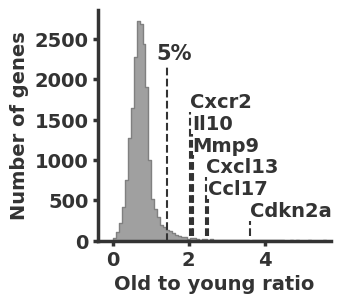

In [16]:
plt.figure(figsize = (3,3))

ax = sns.histplot(data = gpcN[gpcN['24m_r'] < 8 ], x = '24m_r', bins = 100, color = 'gray',element="step")

#draw line at 5 percent
p5 = gpcN.sort_values('24m_r', ascending = False).iloc[int(0.05*len(gpcN))]['24m_r']
ax.axvline(x = p5, color = '0.2', ls = '--', lw = 1.5, ymax = .75)
ax.text(x = p5+.2, y = 2200, s = '5%', ha = 'center', va = 'bottom', color = '0.2', weight = 'bold', size = 15)

selected = selected[selected['24m_r'] > p5]

for mover, gene in enumerate(selected.sort_values('24m_r', ascending = False).index):

    
    mover = 270*mover
    #ax.arrow(df.loc[gene].slope, mover+10, 0, -5, fc='k', ec='k', head_starts_at_zero = True, head_length = 2)

    #if gene != 'Cdkn2a':
    ax.text(gpcN.loc[gene]['24m_r'] , mover+250, gene, size = 14, ha = 'left', va = 'bottom', color = '0.2', weight = 'bold')
    ax.axvline(x = gpcN.loc[gene]['24m_r'], ymax = (mover+ 250)/ax.get_ylim()[1], lw = 1.5, color = '0.2', ls = '--', ymin = 0.02)
    #else:
        #ax.text(gpcN.loc[gene]['24m_r'] , mover+250, 'p16', size = 14, ha = 'left', va = 'bottom', color = '0.2', weight = 'bold')
        #ax.axvline(x = gpcN.loc[gene]['24m_r'], ymax = (mover+ 250)/ax.get_ylim()[1], lw = 1.5, color = '0.2', ls = '--', ymin = 0.02)
        
plt.xlim(right = 5.75)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
    
plt.xticks(size = 14, weight = 'bold', color = '0.2')
plt.yticks(size = 14, weight = 'bold', color = '0.2')

ax.tick_params(width = 2.5, color = '0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Number of genes', size = 14, weight = 'bold', color = '0.2')
plt.xlabel('Old to young ratio', size = 14, weight = 'bold', color = '0.2')


#plt.savefig('/home/ubuntu/s3_mount/senescence/F31_stuff/all_cells_ratio.png', dpi = 300, bbox_inches = 'tight')
#plt.savefig('/home/ubuntu/s3_mount/senescence/F31_stuff/all_cells_ratio.svg', bbox_inches = 'tight')

#plt.savefig('for_poster/all_cells_ratio.png', dpi = 300, bbox_inches = 'tight')

plt.savefig('figures/1B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/1B.svg', bbox_inches = 'tight')

plt.show()


# individual tissues

In [17]:
adata.obs.tissue.cat.categories

Index(['Aorta', 'BAT', 'Bladder', 'Brain_Myeloid', 'Brain_Non-Myeloid',
       'Diaphragm', 'Fat', 'GAT', 'Heart', 'Heart_and_Aorta', 'Kidney',
       'Large_Intestine', 'Limb_Muscle', 'Liver', 'Lung', 'MAT',
       'Mammary_Gland', 'Marrow', 'Pancreas', 'SCAT', 'Skin', 'Spleen',
       'Thymus', 'Tongue', 'Trachea'],
      dtype='object')

In [18]:
#harmonize facs and drop datasets
tissue_mapper = {
    'Aorta': 'Heart_and_Aorta',
    'Heart': 'Heart_and_Aorta',
    'Brain_Myeloid': 'Brain',
    'Brain_Non-Myeloid': 'Brain',
    'BAT': 'Fat',
    'GAT': 'Fat',
    'SCAT': 'Fat',
    'MAT': 'Fat'
}

def the_tissue_mapper(x):
    try:
        return tissue_mapper[x]
    except:
        return x

adata.obs['tissue2'] = adata.obs.tissue.map(the_tissue_mapper).astype('category')

In [19]:
adata.obs.tissue2.cat.categories

Index(['Bladder', 'Brain', 'Diaphragm', 'Fat', 'Heart_and_Aorta', 'Kidney',
       'Large_Intestine', 'Limb_Muscle', 'Liver', 'Lung', 'Mammary_Gland',
       'Marrow', 'Pancreas', 'Skin', 'Spleen', 'Thymus', 'Tongue', 'Trachea'],
      dtype='object')

In [17]:
#remove blood cells from object

In [18]:
#write a csv to make annotation file
#temp = adata.obs.groupby(['tissue2', 'cell_ontology_class'])\
#.count().reset_index()
#temp = temp[temp.age > 0]
#temp[['tissue2', 'cell_ontology_class']].to_csv('../data/annotations/blood_cell_annotation.csv')



#saved then annotated as blood cell manually

#note marrow, and spleen all marked n, because they were all blood cells
#note macrophages marked n

In [20]:
blood_cells_df = pd.read_csv('../data/annotations/blood_cell_annotation.csv')

blood_cells_df['tissue_cell'] = blood_cells_df.tissue2 + "_"+ blood_cells_df.cell_ontology_class

blood_cells_df

,Unnamed: 0,tissue2,cell_ontology_class,blood_cell,tissue_cell
0,21,Bladder,bladder cell,n,Bladder_bladder cell
1,22,Bladder,bladder urothelial cell,n,Bladder_bladder urothelial cell
2,39,Bladder,endothelial cell,n,Bladder_endothelial cell
3,88,Bladder,leukocyte,y,Bladder_leukocyte
4,156,Brain,Bergmann glial cell,n,Brain_Bergmann glial cell
...,...,...,...,...,...
236,2737,Trachea,mesenchymal cell,n,Trachea_mesenchymal cell
237,2738,Trachea,mesenchymal progenitor cell,n,Trachea_mesenchymal progenitor cell
238,2743,Trachea,mucus secreting cell,n,Trachea_mucus secreting cell
239,2749,Trachea,neuroendocrine cell,n,Trachea_neuroendocrine cell


In [21]:
#make adata of only solid tissues, no blood cells: bloodless
bloodless = adata.copy()
bloodless.obs['tissue_cell'] = bloodless.obs.tissue2.astype('str')\
    + "_"+ bloodless.obs.cell_ontology_class.astype('str')

bloodless = bloodless[bloodless.obs.tissue_cell.isin(blood_cells_df[blood_cells_df.blood_cell == 'n'].tissue_cell)]

bloodless = bloodless[~bloodless.obs.tissue.isin(['Spleen', 'Marrow'])] #getting rid of these beacuase all blood

In [22]:
bloodless.obs.head()

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell
index,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte
AAACCTGCAGTAAGCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte
AAACCTGTCATTATCC-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte
AAACGGGGTACAGTGG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte
AAACGGGGTCTTCTCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte


### process immune cells

In [22]:
#make adata of immune cells
# blood = adata.copy()
# blood.obs['tissue_cell'] = blood.obs.tissue2.astype('str')\
#     + "_"+ blood.obs.cell_ontology_class.astype('str')


# blood = blood[(blood.obs.tissue_cell.isin(blood_cells_df[blood_cells_df.blood_cell == 'y'].tissue_cell)) |\
#               (blood.obs.tissue.isin(['Spleen', 'Marrow']))]


#running scvi to integrate the samples because all tissues immune cells are not annotated the same
#e.g., some say just 'leukocytes'

# blood.layers['counts'] = blood.X.copy() #IMPORTANT, this is used by scVI. This will not change
# sc.pp.normalize_total(blood, target_sum = 1e4)
# sc.pp.log1p(blood)
# blood.raw = blood

# sc.pp.highly_variable_genes(blood, n_top_genes=4000, subset = True, layer = 'counts',
#                             flavor = "seurat_v3")

# scvi.model.SCVI.setup_anndata(blood, layer = "counts",
#                              categorical_covariate_keys=["tissue", 'method', 'age'])
# model = scvi.model.SCVI(blood)
# model.train()
# blood.obsm['X_scVI'] = model.get_latent_representation()

# sc.pp.neighbors(blood, use_rep = 'X_scVI')
# sc.tl.umap(blood)
#blood.write('../data/tms/blood_scvi.h5ad')


#if reloading do both below
#blood = sc.read_h5ad('../data/tms/blood_scvi.h5ad')
#sc.tl.leiden(blood)

In [23]:
##dictionary based on the scvi integrated immune cells
##the more specific labels were transfered to the other cells within the same leiden cluster
##if there was low correspondance within a cluster, the cluster is dropped


#blood.obs[blood.obs.leiden == '0'].groupby('cell_ontology_class').count()[['age']].\
#sort_values('age', ascending = False).head(10)


# blood_lieden_d = {'0':'B cell',
# '1':'granulocyte',
# '2':'monocyte',
# '3':'B cell',
# '4':'T cell',
# '5':'T cell',
# '6':'B cell',
# '7':'myloid progenitor',
# '8':'B cell',
# '9':'drop',
# '10':'drop',
# '11':'monocyte',
# '12':'hematopoietic stem cell',
# '13':'monocyte',
# '14':'drop',
# '15':'macrophage',
# '16':'T cell',
# '17':'drop',
# '18':'B cell',
# '19':'B cell',
# '20':'NK cell',
# '21':'granulocyte',
# '22':'plasma cell',
# '23':'monocyte',
# '24':'drop',
# '25':'T cell',
# '26':'granulocyte',
# '27':'naive T cell',
# '28':'drop',
# '29':'immature T cell',
# '30':'monocyte',
# '31':'T cell',
# '32':'immature B cell',
# '33':'B cell',
# '34':'drop',
# '35':'monocyte',
# '36':'B cell',
# '37':'drop',
# '38':'drop',
# '39':'drop'}

# blood.obs['cell_type_2'] = blood.obs.leiden.map(blood_lieden_d)



# #clean up
# blood = blood[blood.obs.cell_type_2 != 'drop']
# #4 only NK or T
# blood = blood[(((blood.obs.cell_ontology_class.str.contains('T cell')) | (blood.obs.cell_ontology_class.str.contains('NK'))) & (blood.obs.leiden == '4'))\
#             | (blood.obs.leiden != '4')]

# #12 only contains hematopoietic
# blood = blood[((blood.obs.cell_ontology_class.str.contains('hematopoietic')) & (blood.obs.leiden == '12')) |\
# (blood.obs.leiden != '12')]

# #15 only macrophage
# blood = blood[((blood.obs.cell_ontology_class == 'macrophage') & (blood.obs.leiden == '15')) |\
# (blood.obs.leiden != '15')]

# #18 contains B cell
# blood = blood[((blood.obs.cell_ontology_class == 'B cell') & (blood.obs.leiden == '18')) |\
# (blood.obs.leiden != '18')]

# blood_cell_mapper = dict(zip(blood.obs.index, blood.obs.cell_type_2))
# with open('../data/annotations/blood_cell_mapper.pickle', 'wb') as handle:
#     pickle.dump(blood_cell_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
with open('../data/annotations/blood_cell_mapper.pickle', 'rb') as handle:
     blood_cell_mapper = pickle.load(handle)


In [24]:
##map the scvi integrated annotations back onto the raw blood adata, then filter, to redo SCVI

blood = adata.copy()
blood.obs['tissue_cell'] = blood.obs.tissue2.astype('str')\
    + "_"+ blood.obs.cell_ontology_class.astype('str')


blood = blood[(blood.obs.tissue_cell.isin(blood_cells_df[blood_cells_df.blood_cell == 'y'].tissue_cell)) |\
              (blood.obs.tissue.isin(['Spleen', 'Marrow']))]

def get_scvi_annotation(x):
    try:
        return blood_cell_mapper[x]
    except:
        return 'drop'

blood.obs['cell_type_2'] = blood.obs.index.map(get_scvi_annotation)

blood = blood[blood.obs.cell_type_2 != 'drop']





/tmp/ipykernel_1529460/3524737711.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  blood.obs['cell_type_2'] = blood.obs.index.map(get_scvi_annotation)


In [25]:
blood.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2
index,,,,,,,,,,,,,,,,,
AAAGCAACACGGTAGA-1-1-0-0-0,18m,0,MACA_18m_F_AORTA_50_AAAGCAACACGGTAGA,leukocyte,NA,leukocyte,droplet,18-F-50,NaN,2511.0,female,nan,Heart_and_Aorta,Aorta,Heart_and_Aorta,Heart_and_Aorta_leukocyte,monocyte
AAAGCAACAGTCAGCC-1-1-0-0-0,18m,0,MACA_18m_F_AORTA_50_AAAGCAACAGTCAGCC,leukocyte,NA,leukocyte,droplet,18-F-50,NaN,2039.0,female,nan,Heart_and_Aorta,Aorta,Heart_and_Aorta,Heart_and_Aorta_leukocyte,monocyte
AAATGCCAGCAATATG-1-1-0-0-0,18m,0,MACA_18m_F_AORTA_50_AAATGCCAGCAATATG,leukocyte,NA,leukocyte,droplet,18-F-50,NaN,2148.0,female,nan,Heart_and_Aorta,Aorta,Heart_and_Aorta,Heart_and_Aorta_leukocyte,monocyte
AAATGCCCATATGCTG-1-1-0-0-0,18m,0,MACA_18m_F_AORTA_50_AAATGCCCATATGCTG,leukocyte,NA,leukocyte,droplet,18-F-50,NaN,2472.0,female,nan,Heart_and_Aorta,Aorta,Heart_and_Aorta,Heart_and_Aorta_leukocyte,monocyte
ACATCAGGTCCGCTGA-1-1-0-0-0,18m,0,MACA_18m_F_AORTA_50_ACATCAGGTCCGCTGA,leukocyte,NA,leukocyte,droplet,18-F-50,NaN,2277.0,female,nan,Heart_and_Aorta,Aorta,Heart_and_Aorta,Heart_and_Aorta_leukocyte,monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,female,KLS,Marrow,nan,Marrow,Marrow_hematopoietic stem cell,hematopoietic stem cell
P9.MAA001883.3_39_F.1.1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,female,B-cells,Marrow,nan,Marrow,Marrow_naive B cell,B cell
P9.MAA001887.3_39_F.1.1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,female,KLS,Marrow,nan,Marrow,Marrow_hematopoietic stem cell,hematopoietic stem cell


In [26]:
##split blood tissue2 to myeloid and lymphoid

temp_d = {'plasma cell':'Lymphoid',
 'naive T cell':'Lymphoid',
 'B cell':'Lymphoid',
 'monocyte':'Myeloid',
 'immature B cell':'Lymphoid',
 'NK cell':'Lymphoid',
 'hematopoietic stem cell':'HSC',
 'immature T cell':'Lymphoid',
 'myloid progenitor':'Myeloid',
 'granulocyte':'Myeloid',
 'T cell':'Lymphoid',
 'macrophage':'Myeloid'}


blood.obs['tissue2'] = blood.obs.cell_type_2.map(temp_d) 

/tmp/ipykernel_1529460/3182627250.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  blood.obs['tissue2'] = blood.obs.cell_type_2.map(temp_d)


In [27]:
bloodless = bloodless.concatenate(blood)

/tmp/ipykernel_1529460/184621923.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  bloodless = bloodless.concatenate(blood)


In [28]:
tissue_counts = bloodless.obs.groupby(['age', 'tissue2'])\
.size().reset_index().rename(columns={0:'Count'})

tissue_counts = tissue_counts[tissue_counts.Count > 0].reset_index(drop = True)

/tmp/ipykernel_1529460/1897002116.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tissue_counts = bloodless.obs.groupby(['age', 'tissue2'])\


In [29]:
tissue_counts

,age,tissue2,Count
0,1m,Bladder,935
1,1m,HSC,74
2,1m,Heart_and_Aorta,858
3,1m,Kidney,2452
4,1m,Limb_Muscle,5151
...,...,...,...
85,30m,Liver,1778
86,30m,Lung,1992
87,30m,Lymphoid,10588
88,30m,Myeloid,16848


In [30]:
len([x for x in markers if x in adata.var_names])

170

In [31]:
 
out = []
for age_tissue_cell in tqdm(tissue_counts.values):
    
    age_sub = bloodless[(bloodless.obs.age == age_tissue_cell[0]) &\
                    (bloodless.obs.tissue2 == age_tissue_cell[1])].X.toarray()
    
    col_out = []
    for gene in list(markers):
        i = np.where(bloodless.var_names == gene)[0][0]
        gene_vals = age_sub[:, i]
        gene_frac = len(gene_vals[gene_vals > 0])/len(gene_vals)
        if gene_frac == 0 and age_tissue_cell[0] in ['1m', '3m']:
            gene_frac = 1/len(gene_vals) #impute 1/num cells if value is 0
        
        col_out.append(gene_frac)
    out.append(col_out)
    
out = np.array(out)

tissue_counts = pd.concat([tissue_counts, pd.DataFrame(out, columns = list(markers))], axis = 1)
tissue_counts

100%|███████████████████████████████████████████| 90/90 [00:46<00:00,  1.92it/s]


,age,tissue2,Count,Cdkn2a,Cdkn2b,Cdkn1a,Cdkn1b,Trp53,Rb1,Glb1,...,Serpine2,Spp1,Tnf,Tnfrsf11b,Tnfrsf1a,Tnfrsf1b,Tubgcp2,Vgf,Wnt16,Wnt2
0,1m,Bladder,935,0.019251,0.162567,0.708021,0.258824,0.462032,0.103743,0.253476,...,0.149733,0.001070,0.008556,0.004278,0.756150,0.077005,0.157219,0.001070,0.001070,0.663102
1,1m,HSC,74,0.013514,0.013514,0.216216,0.270270,0.945946,0.081081,0.581081,...,0.054054,0.027027,0.013514,0.013514,0.513514,0.148649,0.378378,0.013514,0.013514,0.013514
2,1m,Heart_and_Aorta,858,0.005828,0.024476,0.453380,0.192308,0.389277,0.118881,0.122378,...,0.296037,0.008159,0.005828,0.018648,0.687646,0.082751,0.089744,0.001166,0.012821,0.012821
3,1m,Kidney,2452,0.000816,0.023654,0.215742,0.184339,0.222268,0.157423,0.345840,...,0.090131,0.795269,0.012235,0.007749,0.326672,0.017537,0.064029,0.001223,0.007341,0.004078
4,1m,Limb_Muscle,5151,0.005436,0.013007,0.791691,0.127160,0.304989,0.056494,0.105805,...,0.324209,0.016890,0.048534,0.017861,0.711318,0.167540,0.052805,0.002524,0.003106,0.045428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,30m,Liver,1778,0.024747,0.014061,0.781777,0.382452,0.586052,0.212036,0.543870,...,0.003375,0.059055,0.468504,0.006187,0.933633,0.586052,0.152418,0.000562,0.000000,0.048931
86,30m,Lung,1992,0.023092,0.036145,0.608936,0.147088,0.204317,0.119478,0.104920,...,0.041165,0.112952,0.073795,0.006024,0.519578,0.308233,0.053213,0.000000,0.000000,0.012048
87,30m,Lymphoid,10588,0.022195,0.005572,0.053362,0.227805,0.393559,0.095863,0.089441,...,0.033812,0.027295,0.031356,0.000567,0.108519,0.114941,0.059879,0.000094,0.000000,0.000378
88,30m,Myeloid,16848,0.011396,0.002374,0.233796,0.197353,0.189874,0.112595,0.063390,...,0.047305,0.065408,0.059948,0.000059,0.446462,0.251484,0.047602,0.000178,0.000059,0.000415


In [32]:
tissue_stats = pd.DataFrame(columns = ['tissue', 'gene', 'start', 'end', 'gain', 'ratio'])

for tissue in tqdm(tissue_counts.tissue2.unique()):

    temp = tissue_counts[tissue_counts.tissue2 == tissue]

    out = []
    for gene in list(markers):

        try:
            c3m = temp.loc[temp.age == '3m', 'Count'].iloc[0]
            f3m = temp.loc[temp.age == '3m', gene].iloc[0]
        except:
            c3m = 0
            f3m = 0
        try:
            c1m = temp.loc[temp.age == '1m', 'Count'].iloc[0]
            f1m = temp.loc[temp.age == '1m', gene].iloc[0]
        except:
            c1m = 0
            f1m = 0
        try:
            c24m = temp.loc[temp.age == '24m', 'Count'].iloc[0]
            f24m = temp.loc[temp.age == '24m', gene].iloc[0]
        except:
            c24m = 0
            f24m = 0
        try:
            c30m = temp.loc[temp.age == '30m', 'Count'].iloc[0]
            f30m = temp.loc[temp.age == '30m', gene].iloc[0]
        except:
            c30m = 0
            f30m = 0
        try:
            c21m = temp.loc[temp.age == '21m', 'Count'].iloc[0]
            f21m = temp.loc[temp.age == '21m', gene].iloc[0]
        except:
            c21m = 0
            f21m = 0       
            

        if c3m > 200:
            young_start = f3m
        else:
            young_start = (c3m*f3m + c1m*f1m)/(c3m + c1m)

        if c30m > 200:
            old_end = f30m
        elif c30m + c24m > 0:
            old_end = (c30m*f30m + c24m*f24m)/(c30m + c24m)
        else:
            old_end = f21m

        old_gain = old_end - young_start
        old_ratio = old_end/young_start
        
        out.append([tissue, gene, young_start, old_end, old_gain, old_ratio])

    temp2 = pd.DataFrame(out, columns = ['tissue','gene', 'start', 'end', 'gain', 'ratio'])
    tissue_stats = pd.concat([tissue_stats, temp2])
    
tissue_stats #dataframe of known sen genes and their changes in every cell type (with enough cells)

  0%|                                                    | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_1529460/2637967531.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tissue_stats = pd.concat([tissue_stats, temp2])
100%|███████████████████████████████████████████| 19/19 [00:05<00:00,  3.21it/s]


,tissue,gene,start,end,gain,ratio
0,Bladder,Cdkn2a,0.021693,0.008137,-0.013556,0.375092
1,Bladder,Cdkn2b,0.348420,0.395715,0.047295,1.135741
2,Bladder,Cdkn1a,0.957686,0.967182,0.009496,1.009915
3,Bladder,Cdkn1b,0.409480,0.197993,-0.211488,0.483522
4,Bladder,Trp53,0.539904,0.443992,-0.095911,0.822355
...,...,...,...,...,...,...
165,Trachea,Tnfrsf1b,0.185544,0.238379,0.052835,1.284761
166,Trachea,Tubgcp2,0.067388,0.082241,0.014853,1.220414
167,Trachea,Vgf,0.001935,0.002384,0.000449,1.231859
168,Trachea,Wnt16,0.015822,0.003576,-0.012247,0.225988


In [33]:
def filter_cell_stats(df): #these are all fractions, not percents
    df = df[df.start < 0.05] #starts below 5%
    df = df[df.end < 0.3] #ends below 20%
    #df = df[df.end > 0.005] #no genes that end below 1%
    
    df = df[df.gain > .005] #gains at least 1%
    df = df[df.ratio > 2.5] #raito of at least 2
    return df
    

In [34]:
tissue_stats_filtered = filter_cell_stats(tissue_stats)
tissue_stats_filtered

,tissue,gene,start,end,gain,ratio
13,Bladder,Cxcl2,0.037493,0.129645,0.092151,3.457809
27,Bladder,Ccl4,0.009373,0.039870,0.030496,4.253539
28,Bladder,Ccl5,0.012855,0.053431,0.040576,4.156484
34,HSC,Ccl17,0.008380,0.026217,0.017837,3.128589
35,HSC,Ccl19,0.000698,0.005993,0.005294,8.581273
...,...,...,...,...,...,...
115,Trachea,Bmp6,0.016619,0.050060,0.033440,3.012148
121,Trachea,Csf2,0.001821,0.010727,0.008906,5.889824
139,Trachea,Il10,0.007399,0.046484,0.039085,6.282479
162,Trachea,Tnf,0.017530,0.087008,0.069478,4.963430


In [35]:
out = []
for tissue in tissue_stats.tissue.unique():
    temp = []
    for gene in list(markers):
        try:
            temp_val = tissue_stats_filtered.loc[(tissue_stats_filtered.gene == gene) & (tissue_stats_filtered.tissue == tissue), 'ratio'].iloc[0]
        except:
            temp_val = 0
        temp.append(temp_val)
    out.append(temp)
        

In [36]:
ratio_df = pd.DataFrame(out, columns = list(markers), index = tissue_stats.tissue.unique())
ratio_df[ratio_df > 10] = 10
ratio_df = ratio_df[ratio_df.sum(axis = 1) > 0]

ratio_df = ratio_df.T
ratio_df = ratio_df[ratio_df.sum(axis = 1) > 0]
ratio_df = ratio_df[ratio_df.columns.sort_values(ascending = False)]

In [37]:
len(ratio_df)

74

In [38]:
out = []
for tissue in ratio_df.columns:
    for gene in ratio_df.index:
        temp_val = ratio_df.loc[(ratio_df.index == gene), tissue].iloc[0]
        if temp_val > 0:
            temp_val2 = tissue_stats_filtered.loc[(tissue_stats_filtered.gene == gene) &\
                                              (tissue_stats_filtered.tissue == tissue), 'gain'].iloc[0]

            out.append([tissue, gene, temp_val, temp_val2])
                       
scatter_df = pd.DataFrame(out, columns = ['tissue', 'gene', 'ratio', 'gain'])
scatter_df['gain'] = scatter_df['gain']*100

scatter_df['gain'][scatter_df['gain'] > 10] = 10


/tmp/ipykernel_1529460/3158291230.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scatter_df['gain'][scatter_df['gain'] > 10] = 10
/tmp/ipykernel_1529460/3158291230.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy o

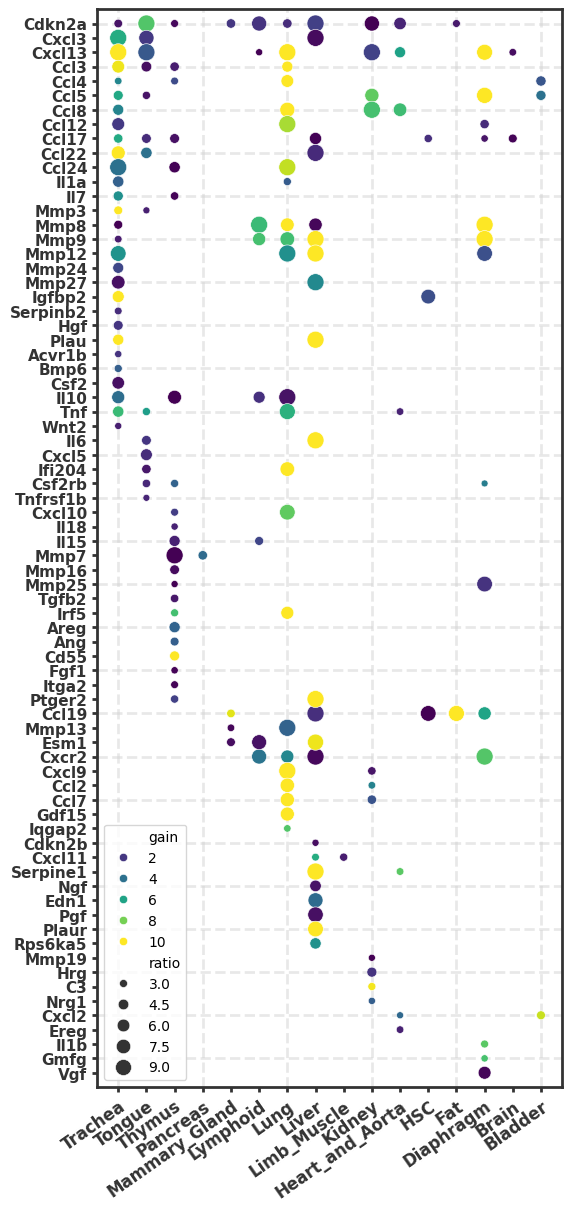

In [39]:
#not used in paper. This is by tissue 

plt.figure(figsize = (6,14))

ax = sns.scatterplot(data = scatter_df, x = 'tissue', y = 'gene', size = 'ratio', hue = 'gain',
                    sizes=(25, 150), palette = 'viridis')


ax.set(ylim=(len(scatter_df.gene.unique()), -1))


for x, y in enumerate(scatter_df.gene.unique()):
    if x%3 == 0:
        ax.axhline(y=y, xmin=0, xmax=1, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
        
for x, y in enumerate(scatter_df.tissue.unique()):
    if x%3 == 0:
        ax.axvline(x=y, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)



plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 11, weight = 'bold', color = '0.2')

plt.xlabel('')
plt.ylabel('')
ax.tick_params(width = 2, color = '0.2')

for axis in ['bottom', 'left', 'right', 'top']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('0.2')
    

plt.show()

In [40]:
#how many tissues is the gene dynamic in

ratio_df_b = ratio_df.copy()
ratio_df_b[ratio_df_b >0] = 1
ratio_df_b['Sum'] = ratio_df_b.sum(axis = 1)

ratio_df_b[['Sum']].sort_values('Sum', ascending = False).head(10)

,Sum
Cdkn2a,10.0
Cxcl13,8.0
Ccl17,7.0
Ccl19,5.0
Mmp8,5.0
Ccl5,5.0
Mmp9,5.0
Ccl4,4.0
Mmp12,4.0
Cxcr2,4.0


In [42]:
###########start cell specific breakdown



In [46]:
bdata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [47]:
class_d = pd.read_csv('../data/annotations/cell_class_annotation.csv')
class_d['class'] = class_d['class'].replace('resident immune', 'immune')

class_d['cell_type_2'] = class_d.cell_ontology_class.map(dict(zip(bdata.obs.cell_ontology_class, bdata.obs.cell_type_2)))


class_d = dict(zip(class_d.cell_type_2, class_d['class']))

class_d['monocyte'] = 'immune' #not sure what happened here

In [48]:
cell_counts = bdata.obs.groupby(['age', 'tissue2', 'cell_type_2'])\
.size().reset_index().rename(columns={0:'Count'})

cell_counts = cell_counts[cell_counts.Count > 125]

cell_counts

/tmp/ipykernel_1529460/2171751061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = bdata.obs.groupby(['age', 'tissue2', 'cell_type_2'])\


,age,tissue2,cell_type_2,Count
14,1m,Bladder,bladder cell,629
15,1m,Bladder,bladder urothelial cell,188
549,1m,Heart_and_Aorta,endothelial cell,368
561,1m,Heart_and_Aorta,fibroblast,266
626,1m,Kidney,Henle thick ascending limb epithelial cell,460
...,...,...,...,...
11298,30m,Myeloid,monocyte,9642
11300,30m,Myeloid,myloid progenitor,2048
11414,30m,Pancreas,pancreatic B cell,276
11417,30m,Pancreas,pancreatic acinar cell,1953


In [49]:
uhh = cell_counts.groupby(['tissue2', 'cell_type_2']).count().reset_index()
uhh = uhh[uhh.age > 1]

uhh

/tmp/ipykernel_1529460/3055919452.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uhh = cell_counts.groupby(['tissue2', 'cell_type_2']).count().reset_index()


,tissue2,cell_type_2,age,Count
14,Bladder,bladder cell,4,4
15,Bladder,bladder urothelial cell,4,4
133,Brain,endothelial cell,3,3
169,Brain,microglial cell,3,3
177,Brain,neuron,3,3
...,...,...,...,...
1780,Tongue,basal cell,4,4
1817,Tongue,keratinocyte,4,4
1884,Trachea,basal cell,3,3
1913,Trachea,fibroblast,3,3


In [1]:
temp = []
for tissue, cell in tqdm(list(zip(uhh.tissue2, uhh.cell_type_2))):
    for age in ['1m', '3m', '18m', '21m', '24m', '30m']:
        
        sdata = bdata[(bdata.obs.tissue2 == tissue) & (bdata.obs.cell_type_2 == cell) &\
                          (bdata.obs.age == age)].X.toarray()
        svars = bdata.var_names
        
        for gene in list(markers):
            temp2 = [tissue, cell, age, gene]
            if len(sdata) > 100:
                i = np.where(svars == gene)[0][0]
                a = sdata[:,i]
                v = a[a > 0].shape[0] / a.shape[0]
                
                if v == 0:
                    v = 1/len(a)
                
            else:
                v = -1
                
            temp2 += [v]
            temp.append(temp2)
                


In [ ]:
tc_df = pd.DataFrame(temp, columns = ['tissue', 'cell_type_2', 'age', 'gene', 'value'])
tc_df = tc_df.pivot(values = 'value', index = ['tissue','cell_type_2', 'gene'], columns = 'age').reset_index()

tc_df = tc_df[[ 'tissue', 'cell_type_2', 'gene', '1m', '3m', '18m', '21m', '24m', '30m']]

In [ ]:
tc_df

In [ ]:
### how many cells, needed to remove the ones with no 1 or 3 m. its removed downstream

tc_df[tc_df[['1m', '3m']].max(axis = 1) > -1].groupby(['tissue', 'cell_type_2']).count().reset_index()

#82

In [ ]:
def gene_stats(x):
    ages = np.array(['1m', '3m', '18m', '21m', '24m', '30m'])
    mask = x > -1
    
    
    
    ages = ages[mask]
    x = x[mask]
    
    if '1m' not in ages and '3m' not in ages:
        return 0,0,0,0
    

    starting = x.iloc[0]
    ending = x.iloc[-1]

    

    return  x.max(), len(x), starting, ending
    
    

In [ ]:
tc_df['Max'], tc_df['N'], tc_df['starting'], tc_df['ending'] =\
zip(*tc_df[['1m', '3m', '18m', '21m', '24m', '30m']].apply(gene_stats, axis = 1))

tc_df['gain'] = tc_df.ending - tc_df.starting
tc_df['ratio'] = tc_df.ending / tc_df.starting

In [50]:
#tc_df.to_csv('../data/files/1_tc_df.csv')

tc_df = pd.read_csv('../data/files/1_tc_df.csv')

In [51]:
def filter_cell_stats(df): #these are all fractions, not percents
    df = df[df.starting < 0.05] #starts below 5%
    df = df[df.ending < 0.3] #ends below 20%
    df = df[df.gain > .01] #gains at least 1%
    df = df[df.ratio > 2.5] #raito of at least 2
    return df
    

tc_df_filt = filter_cell_stats(tc_df)

tc_df_filt 

,Unnamed: 0,tissue,cell_type_2,gene,1m,3m,18m,21m,24m,30m,Max,N,starting,ending,gain,ratio
11,11,Bladder,bladder cell,Bmp6,0.006359,0.075862,0.035539,-1.0,0.039416,-1.0,0.075862,4,0.006359,0.039416,0.033057,6.198175
14,14,Bladder,bladder cell,Ccl11,0.001590,0.024403,0.044118,-1.0,0.059854,-1.0,0.059854,4,0.001590,0.059854,0.058264,37.648175
18,18,Bladder,bladder cell,Ccl2,0.041335,0.122546,0.213235,-1.0,0.153285,-1.0,0.213235,4,0.041335,0.153285,0.111949,3.708310
27,27,Bladder,bladder cell,Ccl5,0.006359,0.012202,0.003676,-1.0,0.048175,-1.0,0.048175,4,0.006359,0.048175,0.041816,7.575547
28,28,Bladder,bladder cell,Ccl7,0.030207,0.084350,0.246324,-1.0,0.140146,-1.0,0.246324,4,0.030207,0.140146,0.109939,4.639570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11857,11857,Trachea,macrophage,Mmp8,-1.000000,0.002024,0.009524,-1.0,0.021277,-1.0,0.021277,3,0.002024,0.021277,0.019252,10.510638
11861,11861,Trachea,macrophage,Ngf,-1.000000,0.004049,0.009524,-1.0,0.021277,-1.0,0.021277,3,0.004049,0.021277,0.017228,5.255319
11872,11872,Trachea,macrophage,Ptges,-1.000000,0.002024,0.009524,-1.0,0.085106,-1.0,0.085106,3,0.002024,0.085106,0.083082,42.042553
11878,11878,Trachea,macrophage,Serpinb2,-1.000000,0.004049,0.028571,-1.0,0.031915,-1.0,0.031915,3,0.004049,0.031915,0.027866,7.882979


In [52]:
len(tc_df_filt.drop_duplicates(['tissue', 'cell_type_2']))

60

In [53]:
temp = tc_df_filt.groupby('gene').count()
temp['Gene'] = temp.index

temp = temp.sort_values(['tissue', 'Gene'], ascending = [False, True])


tissue_count = dict(zip(temp.index, temp.tissue))

temp.head(10)

,Unnamed: 0,tissue,cell_type_2,1m,3m,18m,21m,24m,30m,Max,N,starting,ending,gain,ratio,Gene
gene,,,,,,,,,,,,,,,,
Ccl5,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,Ccl5
Ccl8,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,Ccl8
Cdkn2a,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,Cdkn2a
Cxcl13,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,Cxcl13
Il1b,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,Il1b
Il7,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,Il7
Cdkn2b,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,Cdkn2b
Ccl7,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,Ccl7
Csf2rb,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,Csf2rb


In [55]:
temp = tc_df_filt.groupby(['tissue', 'cell_type_2']).count().sort_values('gene', ascending = False).reset_index()

gene_count = dict(zip(temp.tissue + temp.cell_type_2, temp.gene))

temp.head()

,tissue,cell_type_2,Unnamed: 0,gene,1m,3m,18m,21m,24m,30m,Max,N,starting,ending,gain,ratio
0,Tongue,basal cell,33,33,33,33,33,33,33,33,33,33,33,33,33,33
1,Lung,fibroblast,32,32,32,32,32,32,32,32,32,32,32,32,32,32
2,Liver,hepatocyte,26,26,26,26,26,26,26,26,26,26,26,26,26,26
3,Trachea,macrophage,25,25,25,25,25,25,25,25,25,25,25,25,25,25
4,Heart_and_Aorta,endothelial cell,25,25,25,25,25,25,25,25,25,25,25,25,25,25


In [56]:
tc_df_filt['cell_count'] = tc_df_filt.gene.map(tissue_count)
tc_df_filt['gene_count'] = (tc_df_filt.tissue + tc_df_filt.cell_type_2).map(gene_count)

In [57]:
tc_df_filt['Class'] = tc_df_filt.cell_type_2.map(class_d)

In [58]:
tc_df_filt

,Unnamed: 0,tissue,cell_type_2,gene,1m,3m,18m,21m,24m,30m,Max,N,starting,ending,gain,ratio,cell_count,gene_count,Class
11,11,Bladder,bladder cell,Bmp6,0.006359,0.075862,0.035539,-1.0,0.039416,-1.0,0.075862,4,0.006359,0.039416,0.033057,6.198175,6,12,parenchymal
14,14,Bladder,bladder cell,Ccl11,0.001590,0.024403,0.044118,-1.0,0.059854,-1.0,0.059854,4,0.001590,0.059854,0.058264,37.648175,9,12,parenchymal
18,18,Bladder,bladder cell,Ccl2,0.041335,0.122546,0.213235,-1.0,0.153285,-1.0,0.213235,4,0.041335,0.153285,0.111949,3.708310,12,12,parenchymal
27,27,Bladder,bladder cell,Ccl5,0.006359,0.012202,0.003676,-1.0,0.048175,-1.0,0.048175,4,0.006359,0.048175,0.041816,7.575547,20,12,parenchymal
28,28,Bladder,bladder cell,Ccl7,0.030207,0.084350,0.246324,-1.0,0.140146,-1.0,0.246324,4,0.030207,0.140146,0.109939,4.639570,15,12,parenchymal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11857,11857,Trachea,macrophage,Mmp8,-1.000000,0.002024,0.009524,-1.0,0.021277,-1.0,0.021277,3,0.002024,0.021277,0.019252,10.510638,9,25,immune
11861,11861,Trachea,macrophage,Ngf,-1.000000,0.004049,0.009524,-1.0,0.021277,-1.0,0.021277,3,0.004049,0.021277,0.017228,5.255319,7,25,immune
11872,11872,Trachea,macrophage,Ptges,-1.000000,0.002024,0.009524,-1.0,0.085106,-1.0,0.085106,3,0.002024,0.085106,0.083082,42.042553,4,25,immune
11878,11878,Trachea,macrophage,Serpinb2,-1.000000,0.004049,0.028571,-1.0,0.031915,-1.0,0.031915,3,0.004049,0.031915,0.027866,7.882979,4,25,immune


In [59]:
scatter_df = tc_df_filt.copy()[['tissue', 'cell_type_2', 'Class','gene', 'ending', 'gain']]

scatter_df['tc'] = scatter_df.tissue + scatter_df.cell_type_2

scatter_df['gene_count'] =  scatter_df.tc.map(gene_count)
scatter_df['cell_count'] = scatter_df.gene.map(tissue_count)

scatter_df = scatter_df.drop(columns = ['tc'])
#scatter_df['tc'] = scatter_df.tissue + '_'+ scatter_df.cell_type_2
scatter_df['X'] = scatter_df.tissue + '_'+ scatter_df.Class


scatter_df.gain = scatter_df.gain*100
scatter_df.ending = scatter_df.ending*100

scatter_df = scatter_df[scatter_df.cell_count  > 5] #to save space

scatter_df = scatter_df.sort_values(['X', 'ending'], ascending = [True, False])

scatter_df

,tissue,cell_type_2,Class,gene,ending,gain,gene_count,cell_count,X
199,Bladder,bladder urothelial cell,epithelial,Ccl8,6.792059,5.728229,7,20,Bladder_epithelial
197,Bladder,bladder urothelial cell,epithelial,Ccl5,5.607802,5.075887,7,20,Bladder_epithelial
198,Bladder,bladder urothelial cell,epithelial,Ccl7,5.154998,4.091168,7,15,Bladder_epithelial
188,Bladder,bladder urothelial cell,epithelial,Ccl2,3.099965,2.036135,7,12,Bladder_epithelial
314,Bladder,bladder urothelial cell,epithelial,Rps6ka5,2.159526,1.627611,7,6,Bladder_epithelial
...,...,...,...,...,...,...,...,...,...
11576,Trachea,fibroblast,stromal,Ccl17,3.250000,2.527652,25,7,Trachea_stromal
11595,Trachea,fibroblast,stromal,Cdkn2a,2.500000,1.597065,25,19,Trachea_stromal
11670,Trachea,fibroblast,stromal,Mmp12,1.500000,1.274266,25,7,Trachea_stromal
9613,Myeloid,myloid progenitor,NaN,Il1b,6.689453,5.451829,2,18,NaN


### Figure 1E

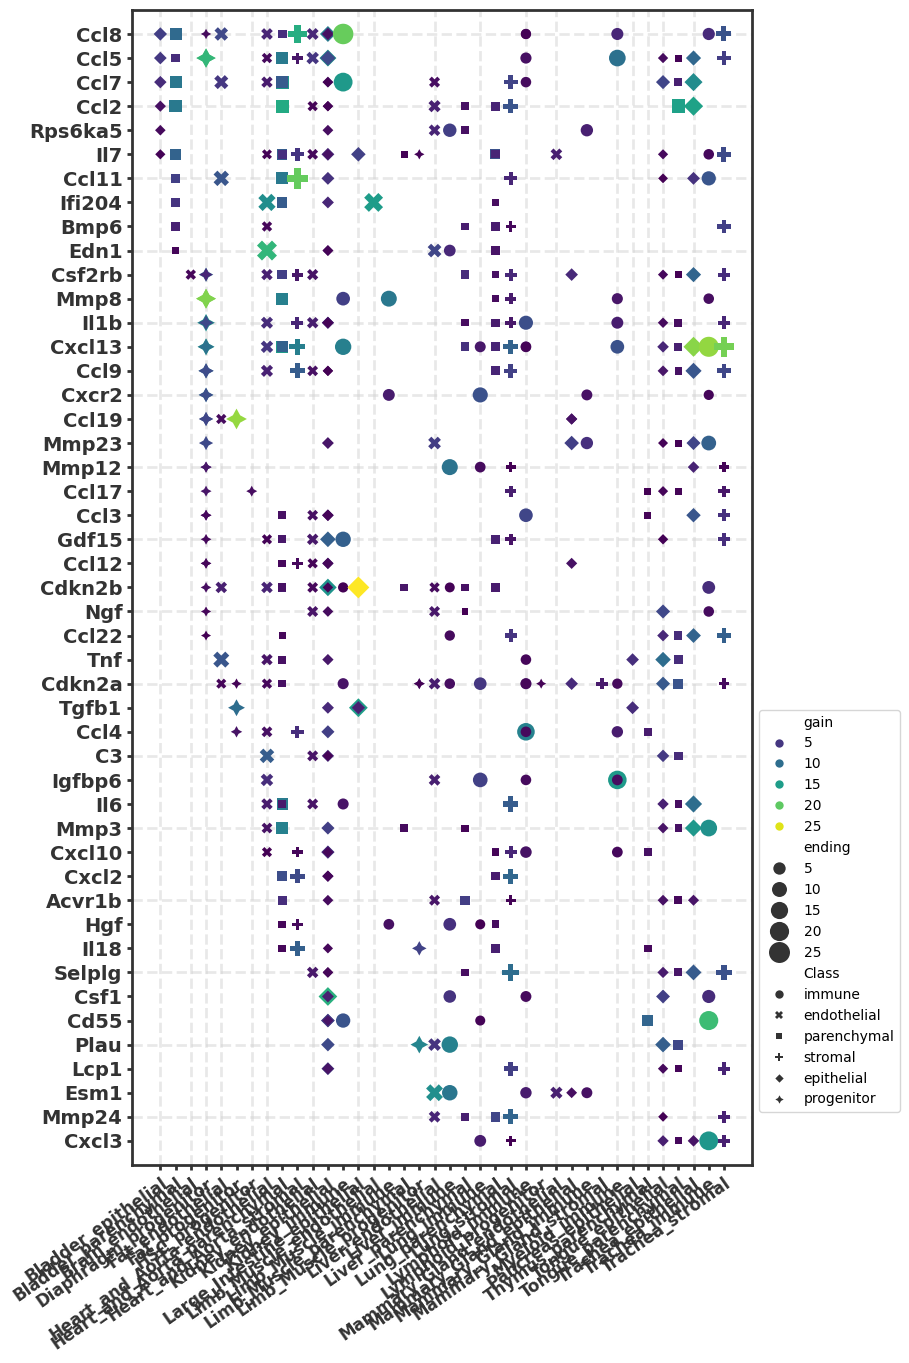

In [60]:
plt.figure(figsize = (8,15))

ax = sns.scatterplot(data = scatter_df, x = 'X', y = 'gene', size = 'ending', hue = 'gain',
                    sizes=(50, 250), palette = 'viridis',
                     style = 'Class', linewidth=0,
                     style_order = ['immune', 'endothelial', 'parenchymal', 'stromal', 'epithelial', 'progenitor']) #, markers = [], style_order =


ax.set(ylim=(len(scatter_df.gene.unique()), -1))


for x, y in enumerate(scatter_df.gene.unique()):
    if x%3 == 0:
        ax.axhline(y=y, xmin=0, xmax=1, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
        

prev = 0
for x in scatter_df[['tissue', 'Class']].drop_duplicates().groupby('tissue').count().values:
    ax.axvline(x=prev, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
    prev += x[0]   

        
plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 14, weight = 'bold', color = '0.2')

plt.xlabel('')
plt.ylabel('')
ax.tick_params(width = 2, color = '0.2')

for axis in ['bottom', 'left', 'right', 'top']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('0.2')

    
ax.legend(bbox_to_anchor=(1, .4))

#plt.savefig('for_poster/tissue_sen_het_human.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('figures/1E_pt1.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/1E_pt1.svg', bbox_inches = 'tight')

plt.show()  

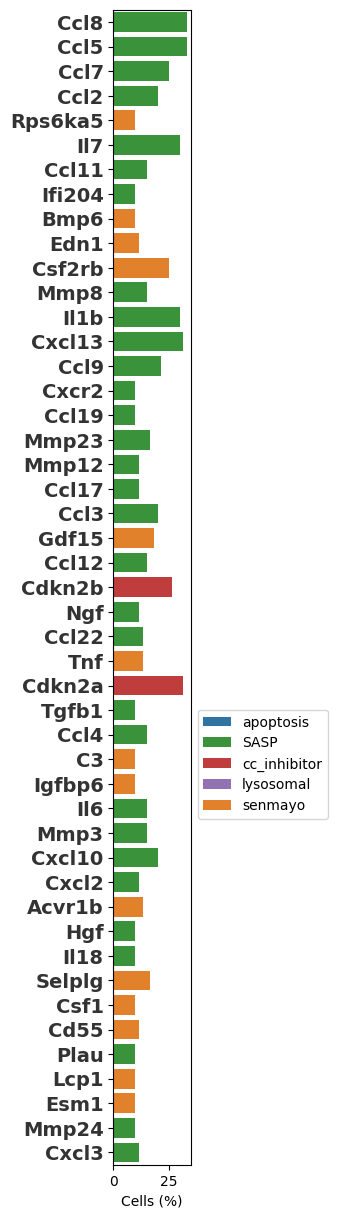

In [61]:
clean_markers = {x:v.split(' ')[0] for (x,v) in markers.items()}

bar_df = scatter_df[['gene', 'cell_count']].drop_duplicates() #.gene.unique().tolist()


bar_df['Cells (%)'] = bar_df.cell_count/len(tc_df_filt.drop_duplicates(['tissue', 'cell_type_2']))*100


bar_df['gene_type'] = bar_df.gene.map(clean_markers)

#temp_color = {'apoptosis':'tab:blue', 'SASP':'tab:green', 'cc_inhibitor':'tab:red', 'lysosomal':'tab:purple'}
#bar_df['colors'] = bar_df.gene_type.map(temp_color)


plt.figure(figsize = (1,15))

ax = sns.barplot(data = bar_df, x = 'Cells (%)', y = 'gene', hue = 'gene_type',dodge=False,
                hue_order = ['apoptosis', 'SASP', 'cc_inhibitor', 'lysosomal', 'senmayo'],
                palette = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:orange'])

ax.legend(bbox_to_anchor=(1, .4))


plt.yticks(size = 14, weight = 'bold', color = '0.2')
plt.ylabel('')

#plt.savefig('for_poster/tissue_sen_het_human_bar.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('figures/1E_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/1E_pt2.svg', bbox_inches = 'tight')

plt.show()

In [33]:
len(tc_df_filt.drop_duplicates(['tissue', 'cell_type_2']))

60

In [61]:
tester = tc_df_filt[['tissue', 'cell_type_2', 'gene']].reset_index(drop = True)

In [62]:
tester

,tissue,cell_type_2,gene
0,Bladder,bladder cell,Bmp6
1,Bladder,bladder cell,Ccl11
2,Bladder,bladder cell,Ccl2
3,Bladder,bladder cell,Ccl5
4,Bladder,bladder cell,Ccl7
...,...,...,...
702,Trachea,macrophage,Mmp8
703,Trachea,macrophage,Ngf
704,Trachea,macrophage,Ptges
705,Trachea,macrophage,Serpinb2


In [107]:
unique_pairs = list(itertools.combinations(tester.drop_duplicates(['tissue', 'cell_type_2']).itertuples(), 2))

In [109]:
len(unique_pairs)

1770

In [110]:
res = []

N = len(markers)


for pair in unique_pairs:
    row1, row2 = pair

    cell1, tis1 = row1.cell_type_2, row1.tissue
    cell2, tis2 = row2.cell_type_2, row2.tissue

    thing1 = tis1 + '-' + cell1
    thing2 = tis2 + '-' + cell2

    if thing1 != thing2:
        genes1 = set(tester[(tester.tissue == tis1) & (tester.cell_type_2 == cell1)]['gene'])
        genes2 = set(tester[(tester.tissue == tis2) & (tester.cell_type_2 == cell2)]['gene'])

        smaller_set = genes1 if len(genes1) < len(genes2) else genes2
        bigger_set = genes1 if len(genes1) > len(genes2) else genes2

        overlap = genes1.intersection(genes2)
        overlap_count = len(overlap)

        union = genes1.union(genes2)
        jaccard_similarity = overlap_count / len(union)


        # Hypergeometric test
        M = len(genes1)  # Number of genes in cell1
        n = len(genes2)  # Number of genes in cell2
        p_value = stats.hypergeom.sf(overlap_count - 1, N, M, n)  # Cumulative probability of observing x or more overlaps


        res.append([thing1, thing2, overlap_count, len(smaller_set), len(bigger_set),
                    jaccard_similarity, p_value])
            
res = pd.DataFrame(res, columns = ['cell1', 'cell2', 'overlap', 'small_size', 'big_size', 'jaccard', 'p'])

In [113]:
res['padj'] = res.p * len(res)

In [115]:
res.sort_values('padj')

,cell1,cell2,overlap,small_size,big_size,jaccard,p,padj
1760,Tongue-basal cell,Tongue-keratinocyte,23,24,33,0.676471,1.277698e-19,2.261525e-16
285,Diaphragm-mesenchymal stem cell,Diaphragm-skeletal muscle satellite cell,14,17,19,0.636364,6.474628e-14,1.146009e-10
1515,Lung-fibroblast,Trachea-fibroblast,18,25,32,0.461538,1.366715e-10,2.419086e-07
1764,Tongue-keratinocyte,Trachea-basal cell,15,24,24,0.454545,8.803598e-10,1.558237e-06
1761,Tongue-basal cell,Trachea-basal cell,16,24,33,0.390244,3.118528e-08,5.519795e-05
...,...,...,...,...,...,...,...,...
957,Kidney-fenestrated cell,Limb_Muscle-macrophage,0,6,21,0.000000,1.000000e+00,1.770000e+03
956,Kidney-fenestrated cell,Limb_Muscle-endothelial cell,0,1,21,0.000000,1.000000e+00,1.770000e+03
955,Kidney-fenestrated cell,Large_Intestine-secretory cell,0,1,21,0.000000,1.000000e+00,1.770000e+03
976,Kidney-fenestrated cell,Mammary_Gland-macrophage,0,9,21,0.000000,1.000000e+00,1.770000e+03


In [117]:
res[res.padj < 0.05].sort_values('padj')

,cell1,cell2,overlap,small_size,big_size,jaccard,p,padj
1760,Tongue-basal cell,Tongue-keratinocyte,23,24,33,0.676471,1.277698e-19,2.261525e-16
285,Diaphragm-mesenchymal stem cell,Diaphragm-skeletal muscle satellite cell,14,17,19,0.636364,6.474628e-14,1.146009e-10
1515,Lung-fibroblast,Trachea-fibroblast,18,25,32,0.461538,1.366715e-10,2.419086e-07
1764,Tongue-keratinocyte,Trachea-basal cell,15,24,24,0.454545,8.803598e-10,1.558237e-06
1761,Tongue-basal cell,Trachea-basal cell,16,24,33,0.390244,3.118528e-08,5.519795e-05
738,Kidney-Henle thick ascending limb epithelial cell,Kidney-epithelial cell of proximal tubule,14,25,25,0.388889,8.241976e-08,1.458830e-04
732,Heart_and_Aorta-myocyte,Trachea-basal cell,13,24,24,0.371429,2.926504e-07,5.179913e-04
663,Heart_and_Aorta-fibroblast,Lung-adventitial cell,9,17,17,0.360000,1.544804e-06,2.734304e-03
911,Kidney-epithelial cell of proximal tubule,Kidney-proximal convoluted tubule epithelial cell,7,8,25,0.269231,4.835764e-06,8.559302e-03
545,Heart_and_Aorta-endocardial cell,Heart_and_Aorta-endothelial cell,11,20,25,0.323529,5.595135e-06,9.903389e-03


In [118]:
len(res[res.padj < 0.05])

16

In [140]:
# Filter the significant pairs
significant_pairs = res[res['padj'] <= 0.05]

# Count the number of significant pairs where both cell types are from the same tissue
same_tissue_count = sum(significant_pairs.apply(lambda row: row['cell1'].split('-')[0] == row['cell2'].split('-')[0], axis=1))

# Compute the proportion of significant pairs that are from the same tissue
same_tissue_proportion = same_tissue_count / len(significant_pairs)

print("Proportion of significant pairs that are from the same tissue:", same_tissue_proportion)


Proportion of significant pairs that are from the same tissue: 0.4375


In [141]:
# Count the number of pairs where both cell types are from the same tissue in the entire dataset
total_same_tissue_count = sum(res.apply(lambda row: row['cell1'].split('-')[0] == row['cell2'].split('-')[0], axis=1))

# Compute the proportion of same-tissue pairs in the entire dataset
total_same_tissue_proportion = total_same_tissue_count / len(res)

print("Proportion of same-tissue pairs in the entire dataset:", total_same_tissue_proportion)


Proportion of same-tissue pairs in the entire dataset: 0.05367231638418079


In [142]:
from scipy.stats import chi2_contingency

# Construct a contingency table
contingency_table = [[same_tissue_count, len(significant_pairs) - same_tissue_count],
                     [total_same_tissue_count - same_tissue_count, (len(res) - len(significant_pairs)) - (total_same_tissue_count - same_tissue_count)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square test p-value:", p_value)


Chi-square test p-value: 3.252545716736352e-10


In [153]:
0.4375/0.05367231638418079

8.151315789473685

In [150]:
significant_pairs = res[res['padj'] <= 0.05]

# Count the number of significant pairs where both cell types are the same
same_cell_type_count = sum(significant_pairs.apply(lambda row: row['cell1'].split('-', 1)[1] == row['cell2'].split('-', 1)[1], axis=1))

# Compute the proportion of significant pairs with the same cell type
same_cell_type_proportion = same_cell_type_count / len(significant_pairs)

print("Proportion of significant pairs with the same cell type:", same_cell_type_proportion)


Proportion of significant pairs with the same cell type: 0.125


In [151]:
# Count the number of pairs where both cell types are the same in the entire dataset
total_same_cell_type_count = sum(res.apply(lambda row: row['cell1'].split('-', 1)[1] == row['cell2'].split('-', 1)[1], axis=1))

# Compute the proportion of same-cell-type pairs in the entire dataset
total_same_cell_type_proportion = total_same_cell_type_count / len(res)

print("Proportion of same-cell-type pairs in the entire dataset:", total_same_cell_type_proportion)


Proportion of same-cell-type pairs in the entire dataset: 0.01638418079096045


In [152]:
# Construct a contingency table for cell types
contingency_table_cell_type = [[same_cell_type_count, len(significant_pairs) - same_cell_type_count],
                               [total_same_cell_type_count - same_cell_type_count, (len(res) - len(significant_pairs)) - (total_same_cell_type_count - same_cell_type_count)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table_cell_type)

print("Chi-square test p-value for cell types:", p_value)


Chi-square test p-value for cell types: 0.014332734914597441


In [154]:
0.125/0.01638418079096045

7.629310344827586

In [162]:
significant_pairs = res[res['padj'] <= 0.05]

cell_type_of_interest = "fibroblast"

# Filter the 'res' DataFrame to keep only the comparisons involving the cell type of interest
res_fibroblast = res[(res['cell1'].str.contains(cell_type_of_interest)) | (res['cell2'].str.contains(cell_type_of_interest))]
significant_pairs_fibroblast = significant_pairs[(significant_pairs['cell1'].str.contains(cell_type_of_interest)) | (significant_pairs['cell2'].str.contains(cell_type_of_interest))]
# Count the number of significant pairs with the same cell type among the pairs involving the cell type of interest
same_cell_type_count_fibroblast = sum(significant_pairs_fibroblast.apply(lambda row: row['cell1'].split('-', 1)[1] == row['cell2'].split('-', 1)[1], axis=1))

# Compute the proportion of significant pairs with the same cell type among the pairs involving the cell type of interest
same_cell_type_proportion_fibroblast = same_cell_type_count_fibroblast / len(significant_pairs_fibroblast)

print("Proportion of significant pairs with the same cell type among the pairs involving the cell type of interest:", same_cell_type_proportion_fibroblast)


Proportion of significant pairs with the same cell type among the pairs involving the cell type of interest: 0.16666666666666666


In [163]:
# Count the number of pairs with the same cell type in the entire dataset involving the cell type of interest
total_same_cell_type_count_fibroblast = sum(res_fibroblast.apply(lambda row: row['cell1'].split('-', 1)[1] == row['cell2'].split('-', 1)[1], axis=1))

# Compute the proportion of same-cell-type pairs in the entire dataset involving the cell type of interest
total_same_cell_type_proportion_fibroblast = total_same_cell_type_count_fibroblast / len(res_fibroblast)

print("Proportion of same-cell-type pairs in the entire dataset involving the cell type of interest:", total_same_cell_type_proportion_fibroblast)


Proportion of same-cell-type pairs in the entire dataset involving the cell type of interest: 0.017241379310344827


In [164]:
# Construct a contingency table for the cell type of interest
contingency_table_fibroblast = [[same_cell_type_count_fibroblast, len(significant_pairs_fibroblast) - same_cell_type_count_fibroblast],
                                [total_same_cell_type_count_fibroblast - same_cell_type_count_fibroblast, (len(res_fibroblast) - len(significant_pairs_fibroblast)) - (total_same_cell_type_count_fibroblast - same_cell_type_count_fibroblast)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table_fibroblast)

print("Chi-square test p-value for the cell type of interest:", p_value)


Chi-square test p-value for the cell type of interest: 0.20561634758738348


In [ ]:
###########end cell specific breakdown

In [38]:
len(scatter_df.drop_duplicates(['tissue', 'cell_type_2']))

56

In [11]:
20/60

0.3333333333333333

In [28]:
#this is important for umaps below
bloodless = bloodless[~bloodless.obs.tissue2.isin(blood.obs.tissue2.unique().tolist())]

In [29]:
bloodless.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2
index,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,NaN
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,NaN
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,NaN
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,NaN
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1-1-0,21m,0,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,NaN
P8_MAA001700_S104.mus-2-1-1-0,21m,0,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,NaN
P9_B000485_S69.mus-2-1-1-0,18m,0,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,NaN


# PLOT UMAP WITH GENE POSITIVITY

In [2]:
#####this is only to plot UMAPS 

#read in the scvi-normalized and processed data, take UMAP coords and save them to the raw data
adata = sc.read_h5ad('../data/tms/TMS_BDATA_UMAP_COORDS.h5ad')
umap_cords = adata.obsm['X_umap']
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')
adata.obsm['X_umap'] = umap_cords

In [3]:
#map cell class annotations on to adata
class_d = pd.read_csv('../data/annotations/cell_class_annotation.csv')
class_d['class'] = class_d['class'].replace('resident immune', 'immune')
class_d['cell_type_2'] = class_d.cell_ontology_class.map(dict(zip(adata.obs.cell_ontology_class, adata.obs.cell_type_2)))
class_d = dict(zip(class_d.cell_type_2, class_d['class']))
class_d['monocyte'] = 'immune' #not sure what happened here haha
class_d['basal cell of epidermis'] = 'parenchymal'
class_d['myloid progenitor'] = 'immune'
class_d['immature B cell'] = 'immune'

adata.obs['Class'] = adata.obs.cell_type_2.map(class_d)

In [4]:
sc.set_figure_params(dpi_save = 600)

### Fig 1C part 2

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


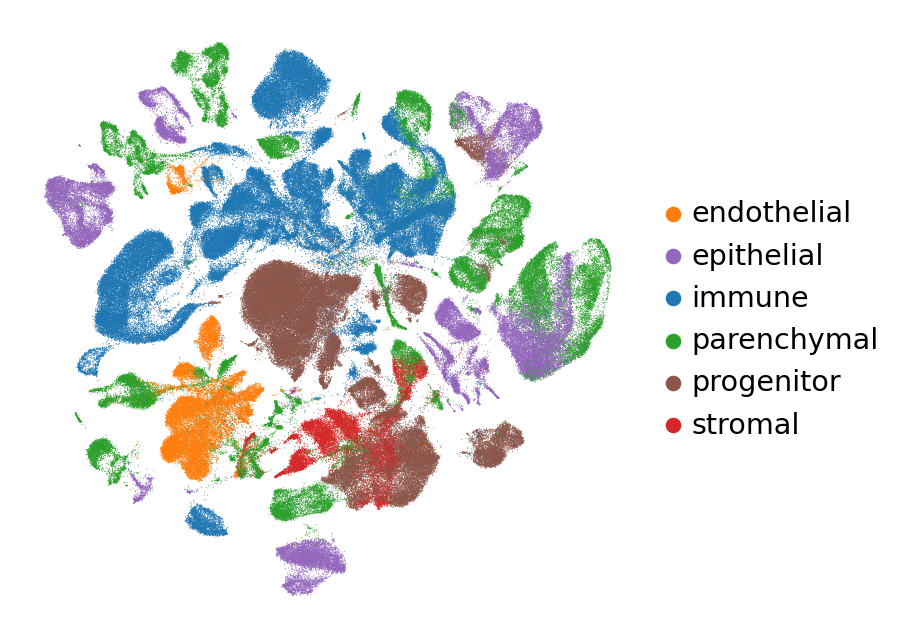

In [68]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, color = 'Class', s = 0.75, frameon=False, title = '', 
                   palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'],
                   save = '_1C_pt2.svg')

### Supp Fig A

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


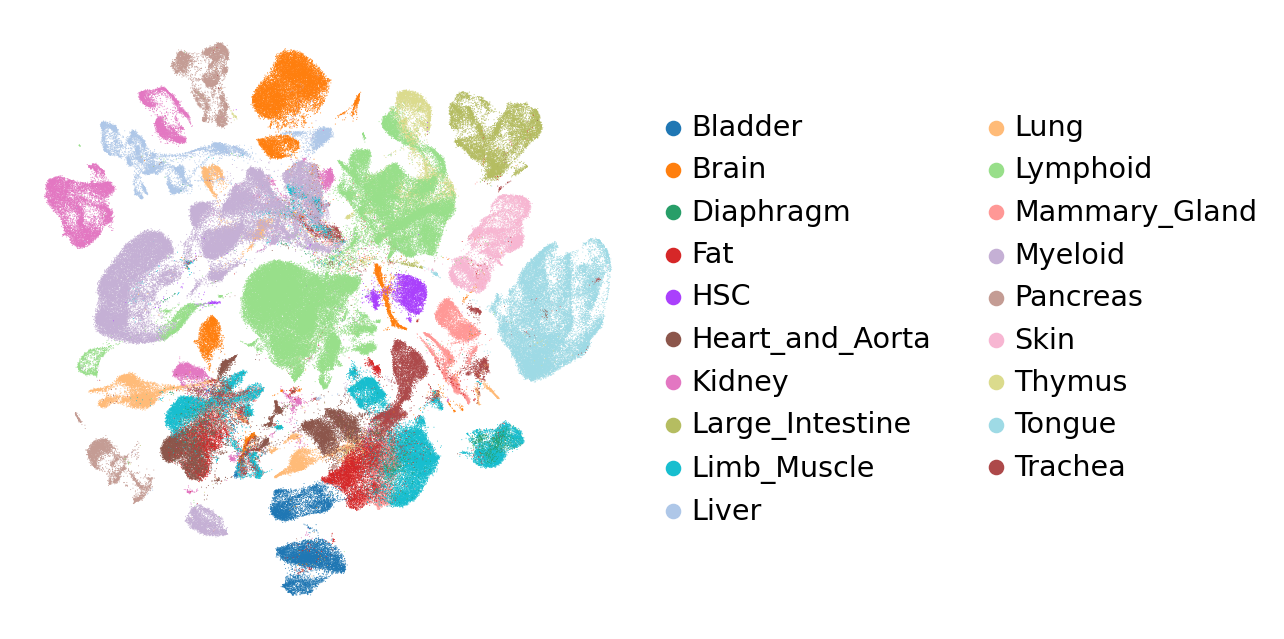

In [70]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, color = 'tissue2', frameon=False, title = '',
                   s = 0.75, save = '_S1A_pt1.svg')

In [6]:
def get_cells_expressing_set(adata, genes, threshold):
    data = adata[:, genes].X.toarray()
    data[data > 0] = 1
    return data.sum(axis = 1) >= threshold

def another_fun_y(x):
    age, thing = x
    if (age == '1m' or age == '3m') and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if (age == '24m' or age == '30m') and thing == 1:
        return 'old pos'
    return 'neg'

In [72]:
#cdkn2a

adata.obs['Cdkn2a+'] = get_cells_expressing_set(adata,['Cdkn2a'], 1)*1
adata.obs['Cdkn2a+_young'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_y, axis = 1)
adata.obs['Cdkn2a+_old'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_o, axis = 1)

### Fig 1C part 1

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

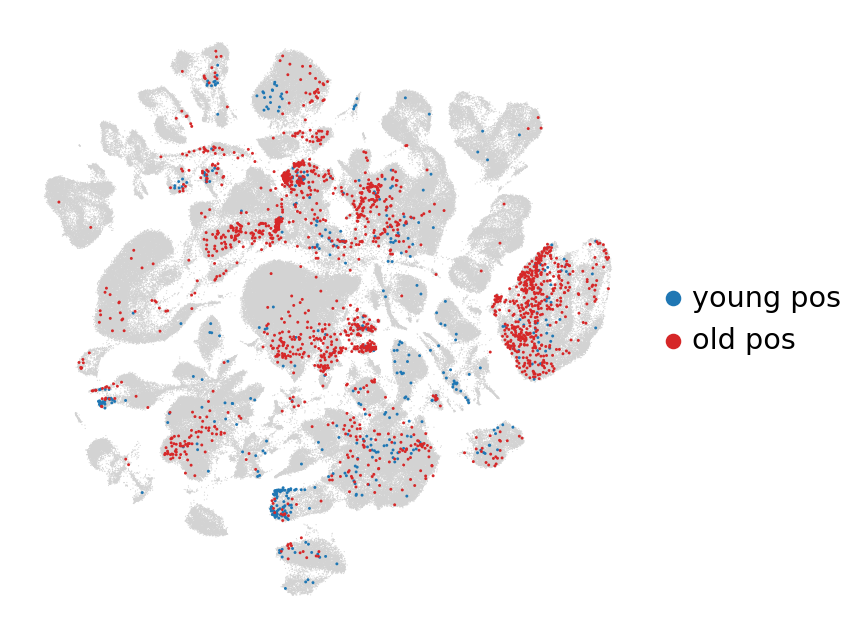

In [75]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = 1,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs['Cdkn2a+_young'] != 'neg'], color = 'Cdkn2a+_young', s = 7, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs['Cdkn2a+_old'] != 'neg'], color = 'Cdkn2a+_old', s = 7, palette = ['tab:red'],
               ax = ax, title = '', save = '_1C_pt1.png')
    
#save = 'tms_p16_pos_all.png'

### Figure 1C part 3

/tmp/ipykernel_1529460/501673860.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


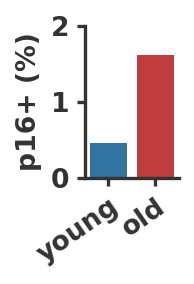

In [76]:
temp_val1 = len(adata.obs[adata.obs['Cdkn2a+_young'] == 'young pos'])\
    /len(adata.obs[adata.obs.age.isin(['1m', '3m'])])*100

temp_val2 = len(adata.obs[adata.obs['Cdkn2a+_old'] == 'old pos'])\
    /len(adata.obs[adata.obs.age.isin(['24m', '30m'])])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('p16+ (%)', size = 12, weight = 'bold', color = '0.2')

plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/1C_pt3.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/1C_pt3.svg', bbox_inches = 'tight')


plt.show()

In [13]:
#Cxcl13

adata.obs['Cdkn2a+'] = get_cells_expressing_set(adata,['Cxcl13'], 1)*1
adata.obs['Cdkn2a+_young'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_y, axis = 1)
adata.obs['Cdkn2a+_old'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_o, axis = 1)

### Sup Fig 3A

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

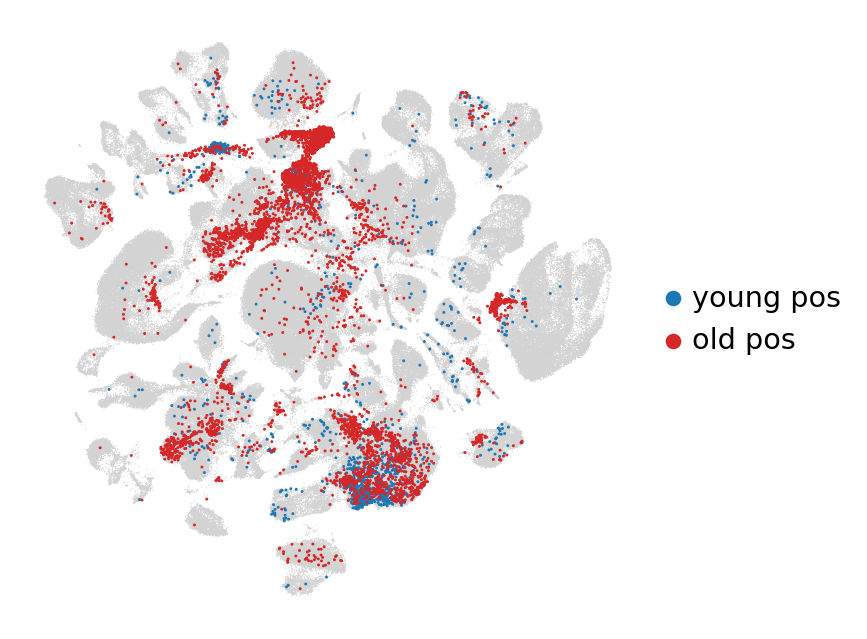

In [14]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = 1,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs['Cdkn2a+_young'] != 'neg'], color = 'Cdkn2a+_young', s = 7, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs['Cdkn2a+_old'] != 'neg'], color = 'Cdkn2a+_old', s = 7, palette = ['tab:red'],
               ax = ax, title = '', save = '_S3A_pt1.png')
    
#save = 'tms_p16_pos_all.png'

/tmp/ipykernel_2016934/3853536769.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


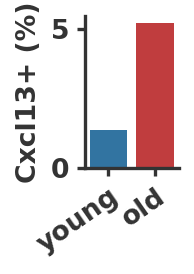

In [9]:
temp_val1 = len(adata.obs[adata.obs['Cdkn2a+_young'] == 'young pos'])\
    /len(adata.obs[adata.obs.age.isin(['1m', '3m'])])*100

temp_val2 = len(adata.obs[adata.obs['Cdkn2a+_old'] == 'old pos'])\
    /len(adata.obs[adata.obs.age.isin(['24m', '30m'])])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('Cxcl13+ (%)', size = 12, weight = 'bold', color = '0.2')

#plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/S3A_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S3A_pt2.svg', bbox_inches = 'tight')


plt.show()

### Sup Fig 1C

In [15]:
#Cdkn1a

adata.obs['Cdkn2a+'] = get_cells_expressing_set(adata,['Cdkn1a'], 1)*1
adata.obs['Cdkn2a+_young'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_y, axis = 1)
adata.obs['Cdkn2a+_old'] = adata.obs[['age', 'Cdkn2a+']].apply(another_fun_o, axis = 1)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


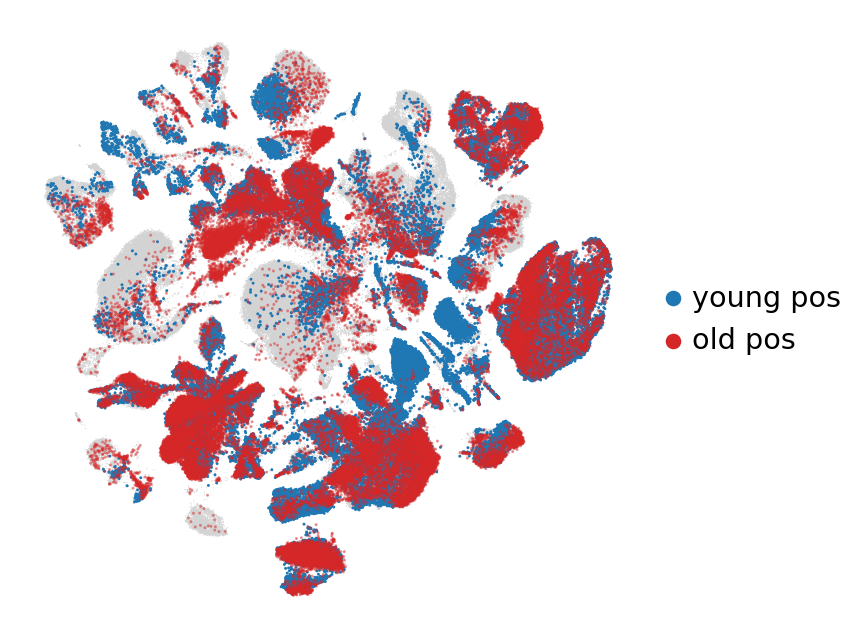

In [16]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = 1,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs['Cdkn2a+_young'] != 'neg'], color = 'Cdkn2a+_young', s = 7, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs['Cdkn2a+_old'] != 'neg'], color = 'Cdkn2a+_old', s = 7, palette = ['tab:red'],
               ax = ax, title = '', alpha = 0.5, save = '_S3C_pt1.png')
    
#save = 'tms_p16_pos_all.png'

/tmp/ipykernel_2016934/517332279.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


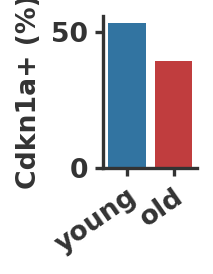

In [12]:
temp_val1 = len(adata.obs[adata.obs['Cdkn2a+_young'] == 'young pos'])\
    /len(adata.obs[adata.obs.age.isin(['1m', '3m'])])*100

temp_val2 = len(adata.obs[adata.obs['Cdkn2a+_old'] == 'old pos'])\
    /len(adata.obs[adata.obs.age.isin(['24m', '30m'])])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('Cdkn1a+ (%)', size = 12, weight = 'bold', color = '0.2')

#plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/S3C_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S3C_pt2.svg', bbox_inches = 'tight')


plt.show()